<a href="https://colab.research.google.com/github/AENatsuKage/KG_with_Neo4j_aura_online_appli_instance_20250610/blob/main/KG_with_Neo4j_aura_online_appli_instance_20250610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Initialization: Repository Reliance `py2neo`

- Toolkit: [neo4j aura](https://console-preview.neo4j.io/)
- Prompt: py2neo installation, and configuration that connect the notebook to neo4j aura.

#### 0.1. Installing `py2neo`

In [6]:
# prompt: py2neo installation, and configuration that connect the notebook to neo4j aura.

!pip install py2neo

#### 0.2. Chinese Font Installation for `matplotlib`
- 解决`matplotlib`中文显示问题

--2025-06-11 07:55:04--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.8.139, 142.251.8.102, 142.251.8.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.8.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-11 07:55:05--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.187.132, 2404:6800:4008:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.187.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2025-06-11 07:55:08 (

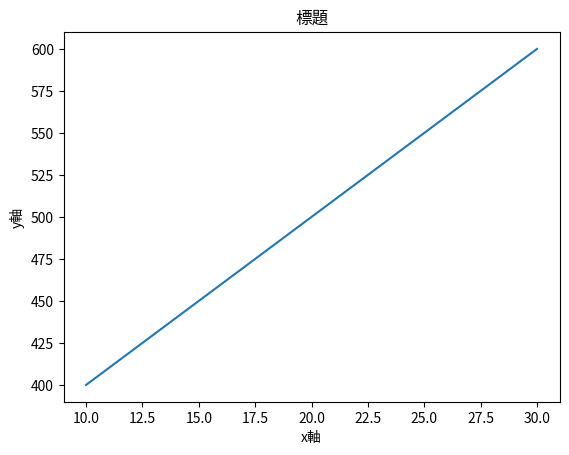

In [7]:
'''
# prompt:
When I'm running jupyter notebooks in Google colab,
how can I configure matplotlib font so that Chinese
characters can be displayed normally?
'''

# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.plot((10,20,30),(400,500,600))
plt.title("標題")
plt.ylabel("y軸")
plt.xlabel("x軸")
plt.show()

#### 0.3. `py2neo` Configuration: Connect the notebook to `neo4j aura`
- [neo4j aura](https://console-preview.neo4j.io/)

In [8]:
from py2neo import Graph, Node, Relationship
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

passkey = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_KG_data_reliance_20250610/py2neo_passkey.csv')

# Replace with your Neo4j Aura connection details
uri = passkey['URI'][0]
user = passkey['USER'][0]
password = passkey['PASSWORD'][0]

graph = Graph(uri, auth=(user, password))

# Optional: Test the connection
try:
    graph.run("MATCH (n) RETURN count(n)")
    print("Successfully connected to Neo4j Aura.")
except Exception as e:
    print(f"Failed to connect to Neo4j Aura: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully connected to Neo4j Aura.


In [9]:
# 清空数据库以防重复
graph.delete_all()

### 1. Initialization: Read DataFrame from Google drive

- `df_fund`: 设备基础信息数据库：`['专业', '系统', '设备', '总体']`
- `df_moni`: 设备故障及监测信息数据库：`["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"]`

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

# prompt: Use pandas to read csv file from my Google drive.

df_fund = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_KG_data_reliance_20250610/data_prcs_equip_fandamental.csv')
df_moni = pd.read_csv('/content/drive/My Drive/Colab Notebooks/_KG_data_reliance_20250610/data_prcs_failure_n_monitoring_utf8.csv')

In [12]:
df_fund

,专业,系统,设备,总体
0,汽机,汽轮机本体,汽轮机本体,汽机设备
1,汽机,汽轮机本体,汽轮机本体疏水气控阀门,汽机设备
2,汽机,汽轮机本体,汽轮机本体疏水手动阀门,汽机设备
3,汽机,调速保安系统,高压自动主汽门,汽机设备
4,汽机,调速保安系统,高压调速汽门,汽机设备
...,...,...,...,...
125,化学,水电解制氢装置,氢气储存罐储罐安全阀,汽机设备
126,化学,水电解制氢装置,制氢装置,汽机设备
127,化学,水电解制氢装置,化学制氢碱液循环泵,汽机设备
128,化学,水电解制氢装置,化学制氢站送水泵,汽机设备


In [13]:
df_moni

,系统,设备,故障现象,故障原因,原因归类,部件,隐患等级,监测技术
0,汽轮机本体及疏水系统,汽轮机本体,汽轮机轴承振动大,轴系质量不平衡,检修不良,转子,子分公司级隐患,安全完整性分析监测技术
1,汽轮机本体及疏水系统,汽轮机本体,汽轮机轴承振动大,对轮不同心,检修不良,对轮,子分公司级隐患,安全完整性分析监测技术
2,汽轮机本体及疏水系统,汽轮机本体,汽轮机轴承振动大,转子弯曲,检修不良,转子,子分公司级隐患,安全完整性分析监测技术
3,汽轮机本体及疏水系统,汽轮机本体,汽轮机轴承振动大,轴承顶隙过大、瓦盖紧力偏小或垫铁接触不良,检修不良,轴承,子分公司级隐患,安全完整性分析监测技术
4,汽轮机本体及疏水系统,汽轮机本体,汽轮机轴承振动大,对轮晃度、飘偏度超标,检修不良,对轮,子分公司级隐患,安全完整性分析监测技术
...,...,...,...,...,...,...,...,...
58,汽轮机本体及疏水系统,汽轮机本体疏水手动阀门,本体疏水手动阀门外漏,自密封填料、盘根填料老化,检修不良,填料,设备缺陷,时序序列关联监测技术
59,汽轮机本体及疏水系统,汽轮机本体疏水手动阀门,本体疏水手动阀门外漏,阀门阀体裂纹或砂眼,制造不良,阀体,设备缺陷,时序序列关联监测技术
60,汽轮机本体及疏水系统,汽轮机本体疏水手动阀门,本体疏水手动阀门内漏,阀门密封面磨损或夹有杂物,检修不良,阀芯及组件,设备缺陷,时序序列关联监测技术
61,汽轮机本体及疏水系统,汽轮机本体疏水手动阀门,本体疏水手动阀门内漏,阀门阀芯阀座密封型线不好,检修不良,阀芯及组件,设备缺陷,时序序列关联监测技术


### 2. Experiment based on Equipment fandamental information `df_fund`

#### 2.1. Fundamental

In [ ]:
from tqdm import tqdm

# 清空数据库以防重复
graph.delete_all()

#### 2.1. Pairing of `专业-系统`

##### 2.1.1. Nodes & Relationship Creation

In [ ]:
# 提取列名
# Original: ['专业', '系统', '设备', '总体'] for df.fund
# ["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"] for df_moni
# columns = ["系统", "设备", "", "", "", "", "", ""]
columns = ["专业", "系统"]

name0 = columns[0]
name1 = columns[1]

df = df_fund[columns]

# 去重处理，防止重复节点和关系
unique_nodes = {col: set(df[col].dropna().unique()) for col in columns}

print("-> Creating Nodes ...")

# 创建节点
node_dict = {col: {} for col in columns}  # 用于存储节点对象以便快速查询
for col in tqdm(columns):
    for value in unique_nodes[col]:
        node = Node(col, name=value)
        graph.create(node)
        node_dict[col][value] = node

print(f"-> Creating {name0}_TO_{name1} Relationships...")

# 创建关系
for _, row in tqdm(df.iterrows()):
    values = {col: row[col] for col in columns if not pd.isna(row[col])}

    # 创建 name0_TO_name1 关系
    if name0 in values and name1 in values:
        src_node = node_dict[name0][values[name0]]
        tgt_node = node_dict[name1][values[name1]]
        rel = Relationship.type(f"{name0}_TO_{name1}")
        graph.merge(rel(src_node, tgt_node))

print(f"-> {name0}_TO_{name1} Relationship Created!")

##### 2.1.2. Weight Assigning:
- 基于元素配对在数据集中的出现次数, 为节点间的关系分配权重

In [ ]:
# prompt: Based on the code above, assign a weight to each name0-name1 pair and add it as an attribute.

# Recalculate the relationships and add a weight attribute
print(f"-> Recalculating {name0}_TO_{name1} Relationships with Weights...")

# Count occurrences of each pair to determine weight
pair_counts = df.groupby(columns).size().reset_index(name='weight')

# Create or update relationships with weights
for _, row in tqdm(pair_counts.iterrows()):
    src_value = row[name0]
    tgt_value = row[name1]
    weight = int(row['weight'])  # Ensure weight is an integer

    src_node = node_dict[name0][src_value]
    tgt_node = node_dict[name1][tgt_value]
    rel_type = f"{name0}_TO_{name1}"

    # Create or merge the relationship with the weight property
    # Using MERGE will find the relationship if it exists and update its properties,
    # or create it if it doesn't exist.
    query = f"""
    MATCH (a:{name0} {{name: $src_name}}), (b:{name1} {{name: $tgt_name}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r.weight = $weight
    """
    graph.run(query, src_name=src_value, tgt_name=tgt_value, weight=weight)

print(f"-> {name0}_TO_{name1} Relationships Updated with Weights!")

In [ ]:
# prompt: Based on the codes above, extract a weight matrix between name0 and name1, and plot a heatmap in matplotlib.

import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract nodes for name0 and name1
query_nodes_name0 = f"MATCH (n:{name0}) RETURN n.name AS name"
nodes_name0_result = graph.run(query_nodes_name0).data()
nodes_name0 = [item['name'] for item in nodes_name0_result]

query_nodes_name1 = f"MATCH (n:{name1}) RETURN n.name AS name"
nodes_name1_result = graph.run(query_nodes_name1).data()
nodes_name1 = [item['name'] for item in nodes_name1_result]

# Create a mapping from node name to index
name0_to_index = {name: i for i, name in enumerate(nodes_name0)}
name1_to_index = {name: i for i, name in enumerate(nodes_name1)}

# Initialize the weight matrix with zeros
weight_matrix = np.zeros((len(nodes_name0), len(nodes_name1)), dtype=int)

# Extract relationships and their weights
query_relationships = f"""
MATCH (a:{name0})-[r:{name0}_TO_{name1}]->(b:{name1})
RETURN a.name AS source, b.name AS target, r.weight AS weight
"""
relationships_result = graph.run(query_relationships).data()

# Populate the weight matrix
for rel in relationships_result:
    source_name = rel['source']
    target_name = rel['target']
    weight = rel['weight']
    if source_name in name0_to_index and target_name in name1_to_index:
        i = name0_to_index[source_name]
        j = name1_to_index[target_name]
        weight_matrix[i, j] = weight

print("Weight Matrix extracted:")
print(weight_matrix)

# Plot the heatmap
plt.figure(figsize=(24, 16))

sns.heatmap(weight_matrix, annot=False, fmt="d", cmap="RdPu",
            xticklabels=nodes_name1, yticklabels=nodes_name0)
plt.xlabel(name1)
plt.ylabel(name0)

plt.title(f"Weight Matrix: {name0} to {name1}")

plt.tight_layout()
plt.show()


#### 2.2. Pairing of `系统-设备`



##### 2.2.1. Node & Relationship Creation

In [ ]:
# 提取列名
# Original: ['专业', '系统', '设备', '总体'] for df.fund
# ["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"] for df_moni
# columns = ["系统", "设备", "", "", "", "", "", ""]
columns = ["系统", "设备"]

name0 = columns[0]
name1 = columns[1]

df = df_fund[columns]

# 去重处理，防止重复节点和关系
unique_nodes = {col: set(df[col].dropna().unique()) for col in columns}

print("-> Creating Nodes ...")

# 创建节点
node_dict = {col: {} for col in columns}  # 用于存储节点对象以便快速查询
for col in tqdm(columns):
    for value in unique_nodes[col]:
        node = Node(col, name=value)
        graph.create(node)
        node_dict[col][value] = node

print(f"-> Creating {name0}_TO_{name1} Relationships...")

# 创建关系
for _, row in tqdm(df.iterrows()):
    values = {col: row[col] for col in columns if not pd.isna(row[col])}

    # 创建 name0_TO_name1 关系
    if name0 in values and name1 in values:
        src_node = node_dict[name0][values[name0]]
        tgt_node = node_dict[name1][values[name1]]
        rel = Relationship.type(f"{name0}_TO_{name1}")
        graph.merge(rel(src_node, tgt_node))

print(f"-> {name0}_TO_{name1} Relationship Created!")

##### 2.2.2. Weight Assigning

- 基于元素配对在数据集中的出现次数, 为节点间的关系分配权重

In [ ]:
# prompt: Based on the code above, assign a weight to each name0-name1 pair and add it as an attribute.

# Recalculate the relationships and add a weight attribute
print(f"-> Recalculating {name0}_TO_{name1} Relationships with Weights...")

# Count occurrences of each pair to determine weight
pair_counts = df.groupby(columns).size().reset_index(name='weight')

# Create or update relationships with weights
for _, row in tqdm(pair_counts.iterrows()):
    src_value = row[name0]
    tgt_value = row[name1]
    weight = int(row['weight'])  # Ensure weight is an integer

    src_node = node_dict[name0][src_value]
    tgt_node = node_dict[name1][tgt_value]
    rel_type = f"{name0}_TO_{name1}"

    # Create or merge the relationship with the weight property
    # Using MERGE will find the relationship if it exists and update its properties,
    # or create it if it doesn't exist.
    query = f"""
    MATCH (a:{name0} {{name: $src_name}}), (b:{name1} {{name: $tgt_name}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r.weight = $weight
    """
    graph.run(query, src_name=src_value, tgt_name=tgt_value, weight=weight)

print(f"-> {name0}_TO_{name1} Relationships Updated with Weights!")

In [ ]:
# prompt: Based on the codes above, extract a weight matrix between name0 and name1, and plot a heatmap in matplotlib.

import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract nodes for name0 and name1
query_nodes_name0 = f"MATCH (n:{name0}) RETURN n.name AS name"
nodes_name0_result = graph.run(query_nodes_name0).data()
nodes_name0 = [item['name'] for item in nodes_name0_result]

query_nodes_name1 = f"MATCH (n:{name1}) RETURN n.name AS name"
nodes_name1_result = graph.run(query_nodes_name1).data()
nodes_name1 = [item['name'] for item in nodes_name1_result]

# Create a mapping from node name to index
name0_to_index = {name: i for i, name in enumerate(nodes_name0)}
name1_to_index = {name: i for i, name in enumerate(nodes_name1)}

# Initialize the weight matrix with zeros
weight_matrix = np.zeros((len(nodes_name0), len(nodes_name1)), dtype=int)

# Extract relationships and their weights
query_relationships = f"""
MATCH (a:{name0})-[r:{name0}_TO_{name1}]->(b:{name1})
RETURN a.name AS source, b.name AS target, r.weight AS weight
"""
relationships_result = graph.run(query_relationships).data()

# Populate the weight matrix
for rel in relationships_result:
    source_name = rel['source']
    target_name = rel['target']
    weight = rel['weight']
    if source_name in name0_to_index and target_name in name1_to_index:
        i = name0_to_index[source_name]
        j = name1_to_index[target_name]
        weight_matrix[i, j] = weight

print("Weight Matrix extracted:")
print(weight_matrix)

# Plot the heatmap
plt.figure(figsize=(24, 16))

sns.heatmap(weight_matrix, annot=False, fmt="d", cmap="RdPu",
            xticklabels=nodes_name1, yticklabels=nodes_name0)
plt.xlabel(name1)
plt.ylabel(name0)

plt.title(f"Weight Matrix: {name0} to {name1}")

plt.tight_layout()
plt.show()


### 3. Experiment based on Equipment Monitoring Dataset `df_moni`

In [14]:
from tqdm import tqdm

# 清空数据库以防重复
graph.delete_all()

#### 3.1. Pairing of `系统-设备`


##### 3.1.1. Nodes & Relationship Creation

In [15]:
# 提取列名
# Original: ['专业', '系统', '设备', '总体'] for df.fund
# ["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"] for df_moni
# columns = ["系统", "设备", "", "", "", "", "", ""]
columns = ["系统", "设备"]

name0 = columns[0]
name1 = columns[1]

df = df_moni[columns]

# 去重处理，防止重复节点和关系
unique_nodes = {col: set(df[col].dropna().unique()) for col in columns}

print("-> Creating Nodes ...")

# 创建节点
node_dict = {col: {} for col in columns}  # 用于存储节点对象以便快速查询
for col in tqdm(columns):
    for value in unique_nodes[col]:
        node = Node(col, name=value)
        graph.create(node)
        node_dict[col][value] = node

print(f"-> Creating {name0}_TO_{name1} Relationships...")

# 创建关系
for _, row in tqdm(df.iterrows()):
    values = {col: row[col] for col in columns if not pd.isna(row[col])}

    # 创建 name0_TO_name1 关系
    if name0 in values and name1 in values:
        src_node = node_dict[name0][values[name0]]
        tgt_node = node_dict[name1][values[name1]]
        rel = Relationship.type(f"{name0}_TO_{name1}")
        graph.merge(rel(src_node, tgt_node))

print(f"-> {name0}_TO_{name1} Relationship Created!")

-> Creating Nodes ...


100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


-> Creating 系统_TO_设备 Relationships...


63it [00:09,  6.80it/s]

-> 系统_TO_设备 Relationship Created!


##### 3.1.2. Weight Assigning
- 基于元素配对在数据集中的出现次数, 为节点间的关系分配权重

In [16]:
# prompt: Based on the code above, assign a weight to each name0-name1 pair and add it as an attribute.

# Recalculate the relationships and add a weight attribute
print(f"-> Recalculating {name0}_TO_{name1} Relationships with Weights...")

# Count occurrences of each pair to determine weight
pair_counts = df.groupby(columns).size().reset_index(name='weight')

# Create or update relationships with weights
for _, row in tqdm(pair_counts.iterrows()):
    src_value = row[name0]
    tgt_value = row[name1]
    weight = int(row['weight'])  # Ensure weight is an integer

    src_node = node_dict[name0][src_value]
    tgt_node = node_dict[name1][tgt_value]
    rel_type = f"{name0}_TO_{name1}"

    # Create or merge the relationship with the weight property
    # Using MERGE will find the relationship if it exists and update its properties,
    # or create it if it doesn't exist.
    query = f"""
    MATCH (a:{name0} {{name: $src_name}}), (b:{name1} {{name: $tgt_name}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r.weight = $weight
    """
    graph.run(query, src_name=src_value, tgt_name=tgt_value, weight=weight)

print(f"-> {name0}_TO_{name1} Relationships Updated with Weights!")

-> Recalculating 系统_TO_设备 Relationships with Weights...


3it [00:00, 13.88it/s]

-> 系统_TO_设备 Relationships Updated with Weights!


Weight Matrix extracted:
[[14 37 12]]


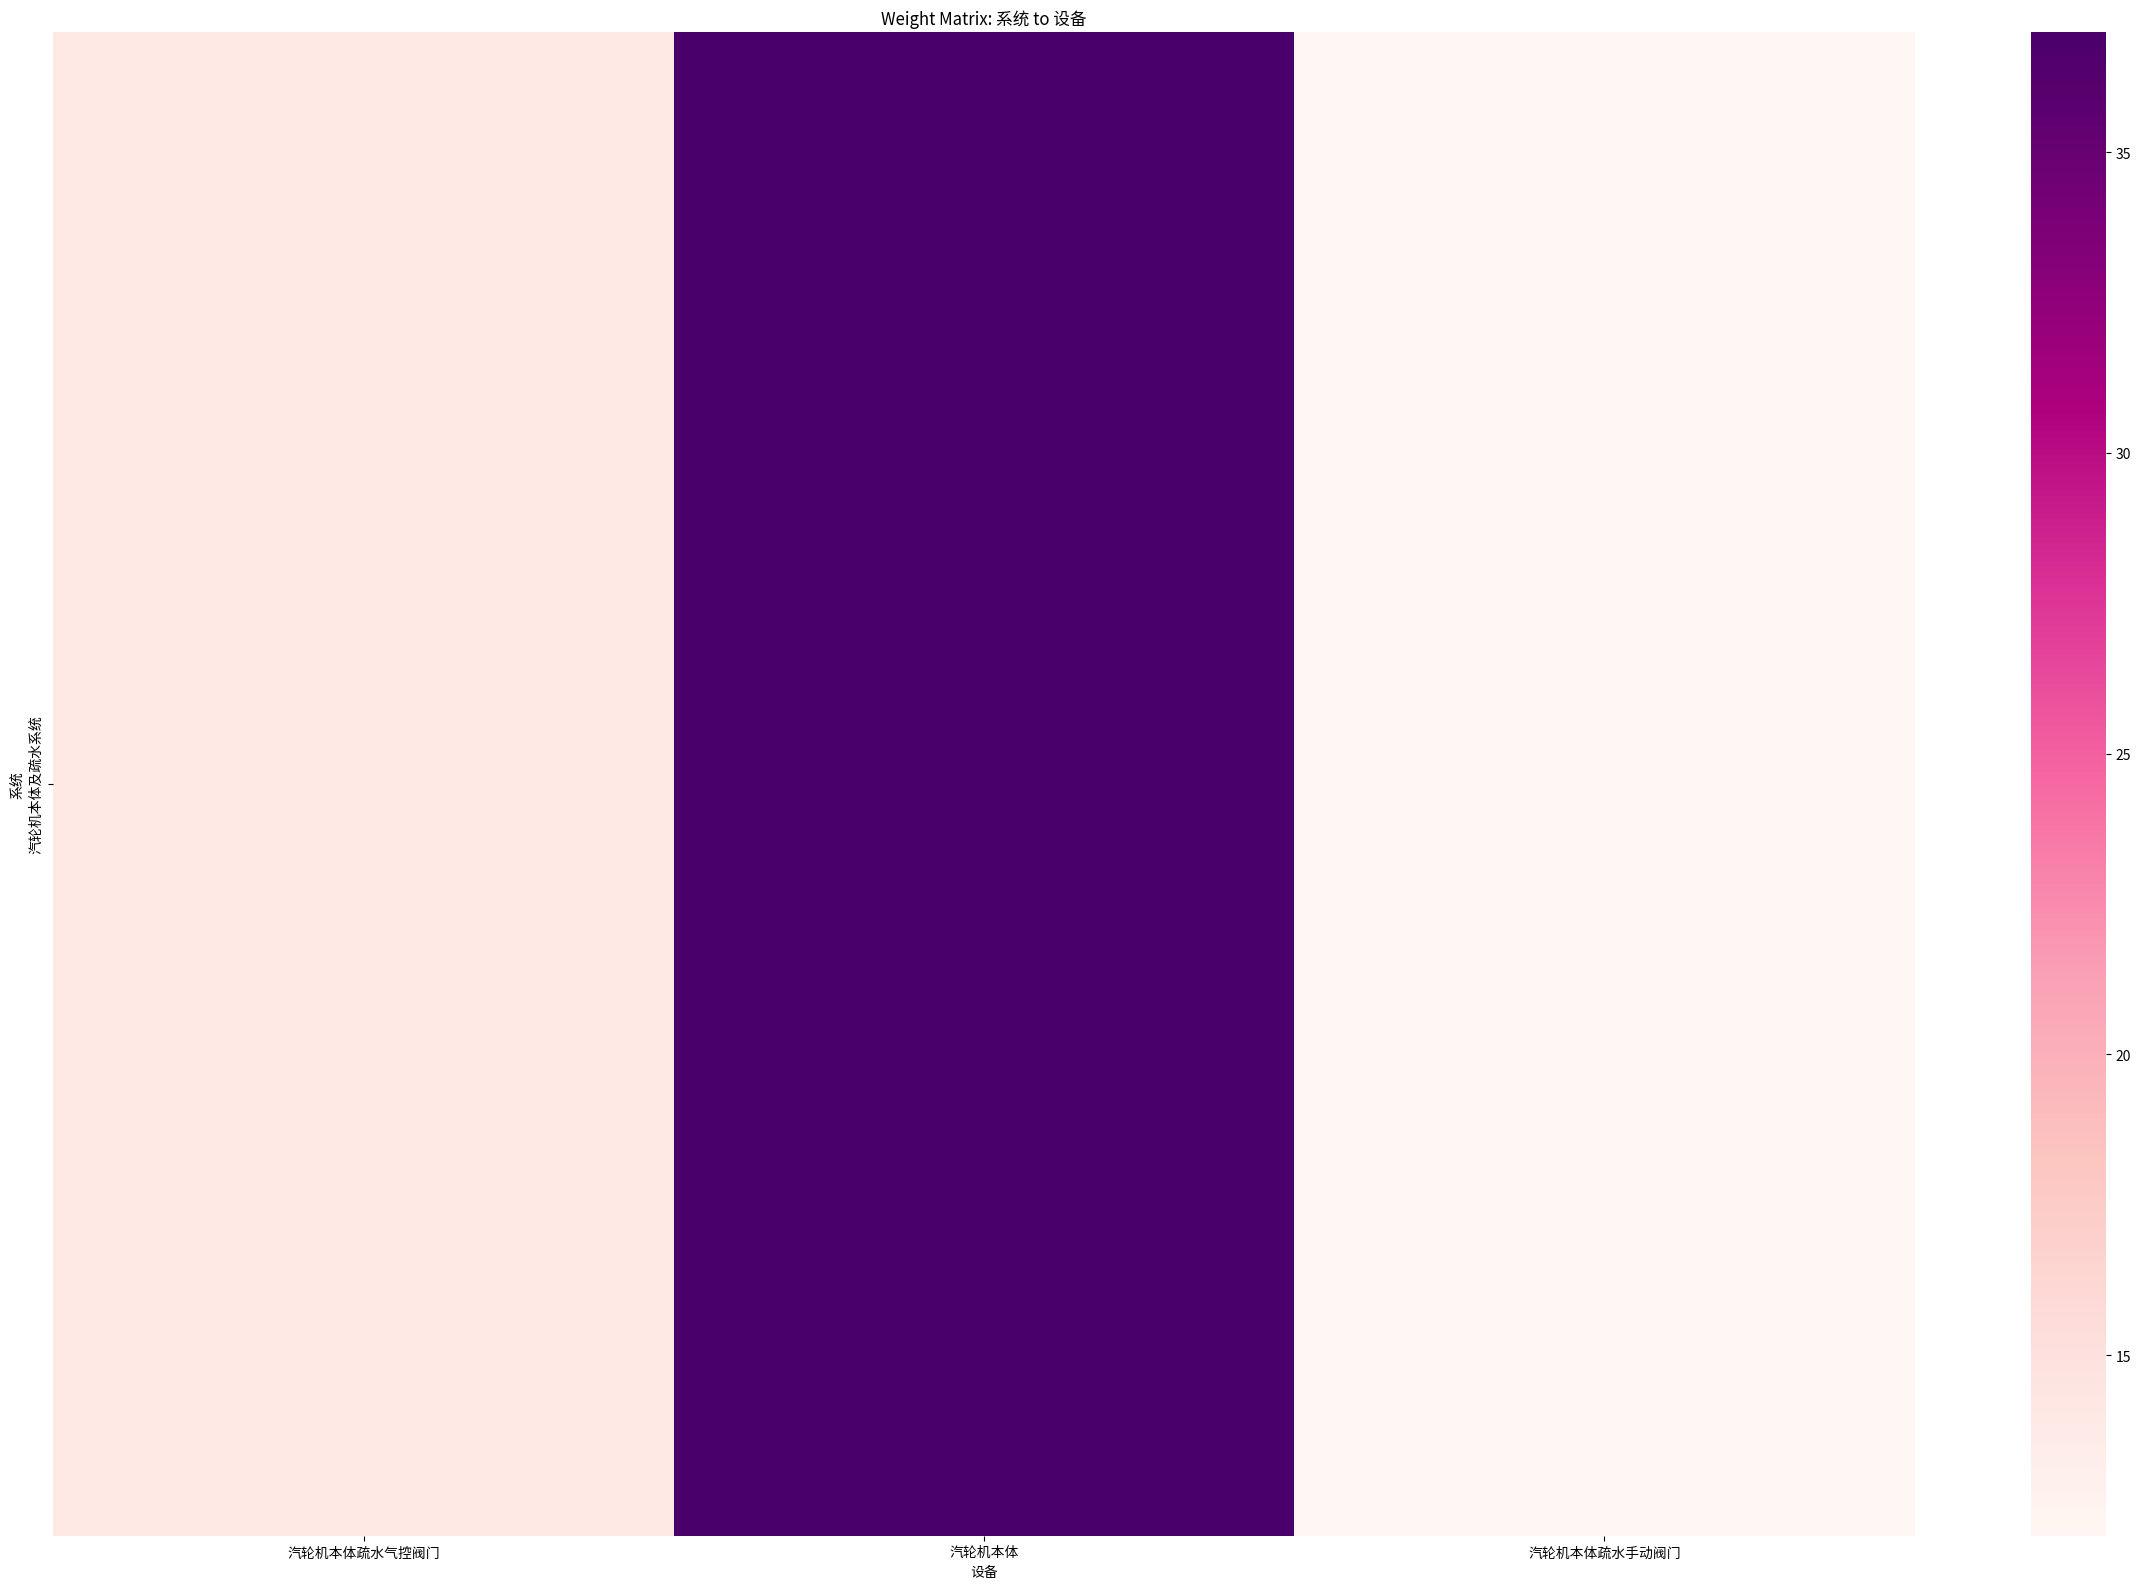

In [17]:
# prompt: Based on the codes above, extract a weight matrix between name0 and name1, and plot a heatmap in matplotlib.

import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract nodes for name0 and name1
query_nodes_name0 = f"MATCH (n:{name0}) RETURN n.name AS name"
nodes_name0_result = graph.run(query_nodes_name0).data()
nodes_name0 = [item['name'] for item in nodes_name0_result]

query_nodes_name1 = f"MATCH (n:{name1}) RETURN n.name AS name"
nodes_name1_result = graph.run(query_nodes_name1).data()
nodes_name1 = [item['name'] for item in nodes_name1_result]

# Create a mapping from node name to index
name0_to_index = {name: i for i, name in enumerate(nodes_name0)}
name1_to_index = {name: i for i, name in enumerate(nodes_name1)}

# Initialize the weight matrix with zeros
weight_matrix = np.zeros((len(nodes_name0), len(nodes_name1)), dtype=int)

# Extract relationships and their weights
query_relationships = f"""
MATCH (a:{name0})-[r:{name0}_TO_{name1}]->(b:{name1})
RETURN a.name AS source, b.name AS target, r.weight AS weight
"""
relationships_result = graph.run(query_relationships).data()

# Populate the weight matrix
for rel in relationships_result:
    source_name = rel['source']
    target_name = rel['target']
    weight = rel['weight']
    if source_name in name0_to_index and target_name in name1_to_index:
        i = name0_to_index[source_name]
        j = name1_to_index[target_name]
        weight_matrix[i, j] = weight

print("Weight Matrix extracted:")
print(weight_matrix)

# Plot the heatmap
plt.figure(figsize=(24, 16))

sns.heatmap(weight_matrix, annot=False, fmt="d", cmap="RdPu",
            xticklabels=nodes_name1, yticklabels=nodes_name0)
plt.xlabel(name1)
plt.ylabel(name0)

plt.title(f"Weight Matrix: {name0} to {name1}")

plt.tight_layout()
plt.show()


#### 3.2. Pairing of `设备-故障现象`



##### 3.2.1. Nodes & Relationship Creation

In [18]:
# 提取列名
# Original: ['专业', '系统', '设备', '总体'] for df.fund
# ["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"] for df_moni
# columns = ["系统", "设备", "", "", "", "", "", ""]
columns = ["设备", "故障现象"]

name0 = columns[0]
name1 = columns[1]

df = df_moni[columns]

# 去重处理，防止重复节点和关系
unique_nodes = {col: set(df[col].dropna().unique()) for col in columns}

print("-> Creating Nodes ...")

# 创建节点
node_dict = {col: {} for col in columns}  # 用于存储节点对象以便快速查询
for col in tqdm(columns):
    for value in unique_nodes[col]:
        node = Node(col, name=value)
        graph.create(node)
        node_dict[col][value] = node

print(f"-> Creating {name0}_TO_{name1} Relationships...")

# 创建关系
for _, row in tqdm(df.iterrows()):
    values = {col: row[col] for col in columns if not pd.isna(row[col])}

    # 创建 name0_TO_name1 关系
    if name0 in values and name1 in values:
        src_node = node_dict[name0][values[name0]]
        tgt_node = node_dict[name1][values[name1]]
        rel = Relationship.type(f"{name0}_TO_{name1}")
        graph.merge(rel(src_node, tgt_node))

print(f"-> {name0}_TO_{name1} Relationship Created!")

-> Creating Nodes ...


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


-> Creating 设备_TO_故障现象 Relationships...


63it [00:09,  6.91it/s]

-> 设备_TO_故障现象 Relationship Created!


##### 3.2.2. Weight Assigning
- 基于元素配对在数据集中的出现次数, 为节点间的关系分配权重

In [ ]:
# prompt: Based on the code above, assign a weight to each name0-name1 pair and add it as an attribute.

# Recalculate the relationships and add a weight attribute
print(f"-> Recalculating {name0}_TO_{name1} Relationships with Weights...")

# Count occurrences of each pair to determine weight
pair_counts = df.groupby(columns).size().reset_index(name='weight')

# Create or update relationships with weights
for _, row in tqdm(pair_counts.iterrows()):
    src_value = row[name0]
    tgt_value = row[name1]
    weight = int(row['weight'])  # Ensure weight is an integer

    src_node = node_dict[name0][src_value]
    tgt_node = node_dict[name1][tgt_value]
    rel_type = f"{name0}_TO_{name1}"

    # Create or merge the relationship with the weight property
    # Using MERGE will find the relationship if it exists and update its properties,
    # or create it if it doesn't exist.
    query = f"""
    MATCH (a:{name0} {{name: $src_name}}), (b:{name1} {{name: $tgt_name}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r.weight = $weight
    """
    graph.run(query, src_name=src_value, tgt_name=tgt_value, weight=weight)

print(f"-> {name0}_TO_{name1} Relationships Updated with Weights!")

In [ ]:
# prompt: Based on the codes above, extract a weight matrix between name0 and name1, and plot a heatmap in matplotlib.

import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract nodes for name0 and name1
query_nodes_name0 = f"MATCH (n:{name0}) RETURN n.name AS name"
nodes_name0_result = graph.run(query_nodes_name0).data()
nodes_name0 = [item['name'] for item in nodes_name0_result]

query_nodes_name1 = f"MATCH (n:{name1}) RETURN n.name AS name"
nodes_name1_result = graph.run(query_nodes_name1).data()
nodes_name1 = [item['name'] for item in nodes_name1_result]

# Create a mapping from node name to index
name0_to_index = {name: i for i, name in enumerate(nodes_name0)}
name1_to_index = {name: i for i, name in enumerate(nodes_name1)}

# Initialize the weight matrix with zeros
weight_matrix = np.zeros((len(nodes_name0), len(nodes_name1)), dtype=int)

# Extract relationships and their weights
query_relationships = f"""
MATCH (a:{name0})-[r:{name0}_TO_{name1}]->(b:{name1})
RETURN a.name AS source, b.name AS target, r.weight AS weight
"""
relationships_result = graph.run(query_relationships).data()

# Populate the weight matrix
for rel in relationships_result:
    source_name = rel['source']
    target_name = rel['target']
    weight = rel['weight']
    if source_name in name0_to_index and target_name in name1_to_index:
        i = name0_to_index[source_name]
        j = name1_to_index[target_name]
        weight_matrix[i, j] = weight

print("Weight Matrix extracted:")
print(weight_matrix)

# Plot the heatmap
plt.figure(figsize=(24, 16))

sns.heatmap(weight_matrix, annot=False, fmt="d", cmap="RdPu",
            xticklabels=nodes_name1, yticklabels=nodes_name0)
plt.xlabel(name1)
plt.ylabel(name0)

plt.title(f"Weight Matrix: {name0} to {name1}")

plt.tight_layout()
plt.show()


#### 3.3. Pairing of `故障现象-故障原因`



##### 3.2.1. Nodes & Relationship Creation

In [19]:
# 提取列名
# Original: ['专业', '系统', '设备', '总体'] for df.fund
# ["系统", "设备", "故障现象", "故障原因", "原因归类", "部件", "隐患等级", "监测技术"] for df_moni
# columns = ["系统", "设备", "", "", "", "", "", ""]
columns = ["故障现象", "故障原因"]

name0 = columns[0]
name1 = columns[1]

df = df_moni[columns]

# 去重处理，防止重复节点和关系
unique_nodes = {col: set(df[col].dropna().unique()) for col in columns}

print("-> Creating Nodes ...")

# 创建节点
node_dict = {col: {} for col in columns}  # 用于存储节点对象以便快速查询
for col in tqdm(columns):
    for value in unique_nodes[col]:
        node = Node(col, name=value)
        graph.create(node)
        node_dict[col][value] = node

print(f"-> Creating {name0}_TO_{name1} Relationships...")

# 创建关系
for _, row in tqdm(df.iterrows()):
    values = {col: row[col] for col in columns if not pd.isna(row[col])}

    # 创建 name0_TO_name1 关系
    if name0 in values and name1 in values:
        src_node = node_dict[name0][values[name0]]
        tgt_node = node_dict[name1][values[name1]]
        rel = Relationship.type(f"{name0}_TO_{name1}")
        graph.merge(rel(src_node, tgt_node))

print(f"-> {name0}_TO_{name1} Relationship Created!")

-> Creating Nodes ...


100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


-> Creating 故障现象_TO_故障原因 Relationships...


63it [00:09,  6.92it/s]

-> 故障现象_TO_故障原因 Relationship Created!


##### 3.2.2. Weight Assigning
- 基于元素配对在数据集中的出现次数, 为节点间的关系分配权重

In [20]:
# prompt: Based on the code above, assign a weight to each name0-name1 pair and add it as an attribute.

# Recalculate the relationships and add a weight attribute
print(f"-> Recalculating {name0}_TO_{name1} Relationships with Weights...")

# Count occurrences of each pair to determine weight
pair_counts = df.groupby(columns).size().reset_index(name='weight')

# Create or update relationships with weights
for _, row in tqdm(pair_counts.iterrows()):
    src_value = row[name0]
    tgt_value = row[name1]
    weight = int(row['weight'])  # Ensure weight is an integer

    src_node = node_dict[name0][src_value]
    tgt_node = node_dict[name1][tgt_value]
    rel_type = f"{name0}_TO_{name1}"

    # Create or merge the relationship with the weight property
    # Using MERGE will find the relationship if it exists and update its properties,
    # or create it if it doesn't exist.
    query = f"""
    MATCH (a:{name0} {{name: $src_name}}), (b:{name1} {{name: $tgt_name}})
    MERGE (a)-[r:{rel_type}]->(b)
    SET r.weight = $weight
    """
    graph.run(query, src_name=src_value, tgt_name=tgt_value, weight=weight)

print(f"-> {name0}_TO_{name1} Relationships Updated with Weights!")

-> Recalculating 故障现象_TO_故障原因 Relationships with Weights...


63it [00:03, 18.19it/s]

-> 故障现象_TO_故障原因 Relationships Updated with Weights!


Weight Matrix extracted:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


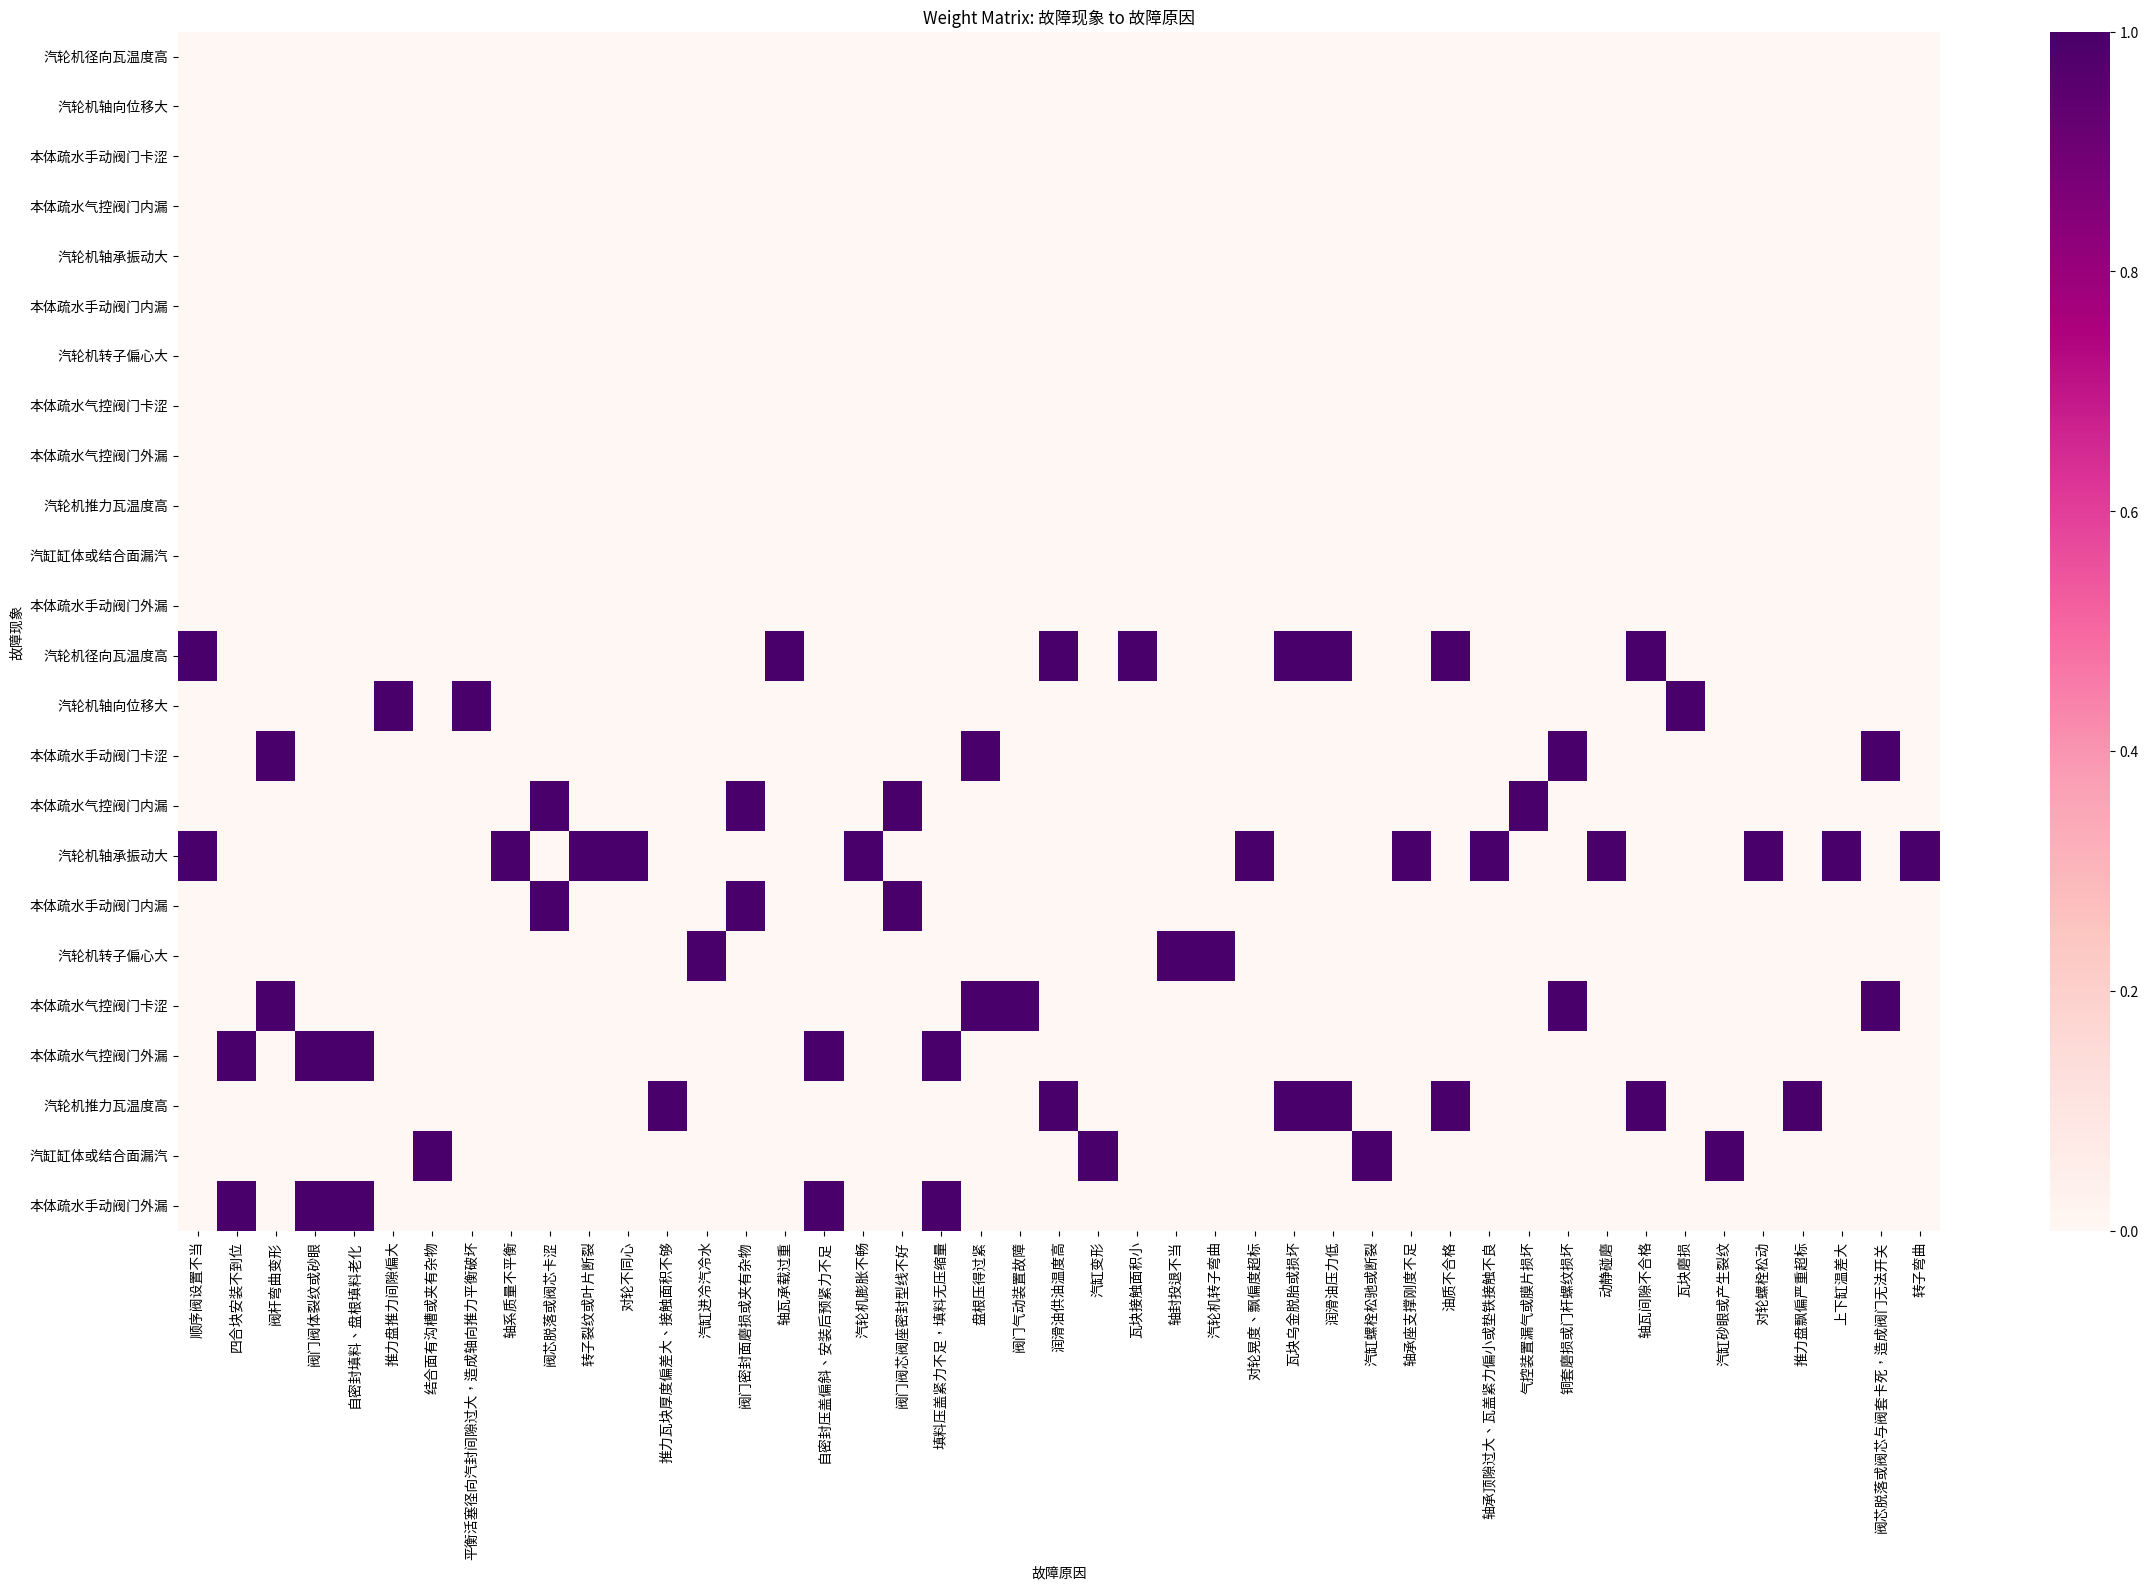

In [21]:
# prompt: Based on the codes above, extract a weight matrix between name0 and name1, and plot a heatmap in matplotlib.

import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extract nodes for name0 and name1
query_nodes_name0 = f"MATCH (n:{name0}) RETURN n.name AS name"
nodes_name0_result = graph.run(query_nodes_name0).data()
nodes_name0 = [item['name'] for item in nodes_name0_result]

query_nodes_name1 = f"MATCH (n:{name1}) RETURN n.name AS name"
nodes_name1_result = graph.run(query_nodes_name1).data()
nodes_name1 = [item['name'] for item in nodes_name1_result]

# Create a mapping from node name to index
name0_to_index = {name: i for i, name in enumerate(nodes_name0)}
name1_to_index = {name: i for i, name in enumerate(nodes_name1)}

# Initialize the weight matrix with zeros
weight_matrix = np.zeros((len(nodes_name0), len(nodes_name1)), dtype=int)

# Extract relationships and their weights
query_relationships = f"""
MATCH (a:{name0})-[r:{name0}_TO_{name1}]->(b:{name1})
RETURN a.name AS source, b.name AS target, r.weight AS weight
"""
relationships_result = graph.run(query_relationships).data()

# Populate the weight matrix
for rel in relationships_result:
    source_name = rel['source']
    target_name = rel['target']
    weight = rel['weight']
    if source_name in name0_to_index and target_name in name1_to_index:
        i = name0_to_index[source_name]
        j = name1_to_index[target_name]
        weight_matrix[i, j] = weight

print("Weight Matrix extracted:")
print(weight_matrix)

# Plot the heatmap
plt.figure(figsize=(24, 16))

sns.heatmap(weight_matrix, annot=False, fmt="d", cmap="RdPu",
            xticklabels=nodes_name1, yticklabels=nodes_name0)
plt.xlabel(name1)
plt.ylabel(name0)

plt.title(f"Weight Matrix: {name0} to {name1}")

plt.tight_layout()
plt.show()
